### Baseline model for predicting reccomended book

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


### Import dataset, split into train/val/test

In [6]:
df = pd.read_csv('model_data/model_data_wo_eXtern.csv')

df.head(5)

,User-ID,Age,City,Region/State,Country,Age_Missing,ISBN,Book-Rating,Rating_Categ,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2,18.0,stockton,california,usa,0,0195153448,0,Not rated,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,7,-1.0,washington,dc,usa,1,034542252,0,Not rated,NaN,NaN,NaN,NaN
2,8,-1.0,timmins,ontario,canada,1,0002005018,5,Avarege (4-5),Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,8,-1.0,timmins,ontario,canada,1,0060973129,0,Not rated,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
4,8,-1.0,timmins,ontario,canada,1,0374157065,0,Not rated,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux


### Remove not rated

In [7]:
### Unique values and counts from rating_categ
df['Rating_Categ'].value_counts()

Rating_Categ
Not rated           716109
Excellent (8-10)    249887
Good (6-7)          113381
Avarege (4-5)        59878
Bad (1-3)            10525
Name: count, dtype: int64

In [8]:

## Rating counts 
rating_counts = df['Book-Rating'].value_counts()

## Sort by index
rating_counts = pd.DataFrame(rating_counts.sort_index())
## Calcualte percentages also and add as another column
rating_counts['percentage'] = round(rating_counts/rating_counts.sum()*100,1)

## Add cumulative percentage
rating_counts['cumulative_percentage'] = rating_counts['percentage'].cumsum()



rating_counts

,count,percentage,cumulative_percentage
Book-Rating,,,
0,716109,62.3,62.3
1,1770,0.2,62.5
2,2759,0.2,62.7
3,5996,0.5,63.2
4,8904,0.8,64.0
5,50974,4.4,68.4
6,36924,3.2,71.6
7,76457,6.6,78.2
8,103736,9.0,87.2


In [9]:
### Create a new binary category for rating (everything above 8 is 1, otherwise 0)

df['Reccomnend'] = np.where(df['Book-Rating'] >= 8, 1, 0)

In [10]:
## Remove not rated
df = df[df['Rating_Categ'] != 'Not rated']
df['Rating_Categ'].value_counts()

Rating_Categ
Excellent (8-10)    249887
Good (6-7)          113381
Avarege (4-5)        59878
Bad (1-3)            10525
Name: count, dtype: int64

In [11]:
df['Reccomnend'].value_counts()

Reccomnend
1    249887
0    183784
Name: count, dtype: int64

Split into train/test/val

In [12]:
### Split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 80% Train
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 10% Val, 10% Test

del(temp_df)

print(f"Train samples:\t\t {len(train_df)/1000} k")
print(f"Validation samples:\t {len(val_df)/1000} k")
print(f"Test samples:\t\t {len(test_df)/1000} k")

Train samples:		 260.202 k
Validation samples:	 86.734 k
Test samples:		 86.735 k


Select features and targets

In [13]:
df.columns

Index(['User-ID', 'Age', 'City', 'Region/State', 'Country', 'Age_Missing',
       'ISBN', 'Book-Rating', 'Rating_Categ', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'Reccomnend'],
      dtype='object')

In [14]:
#features = ['Age', 'City', 'Region/State', 'Country', 'Age_Missing','Year-Of-Publication']
features = ['Age', 'Age_Missing','Year-Of-Publication']
target_class = 'Reccomnend'
target_reg = 'Book-Rating'

In [15]:
X_train = train_df.loc[:,features]
y_train = train_df.loc[:,target_class]

X_val = val_df.loc[:,features]
y_val = val_df.loc[:,target_class]

X_test = test_df.loc[:,features]
y_test = test_df.loc[:,target_class]

y_train_reg = train_df.loc[:,target_reg]
y_val_reg = val_df.loc[:,target_reg]
y_test_reg = test_df.loc[:,target_reg]


In [28]:
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

In [29]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of the resampled data
print(f"Original training set class distribution: {y_train.value_counts()}")
print(f"Resampled training set class distribution: {y_train_resampled.value_counts()}")

Original training set class distribution: Reccomnend
1    149920
0    110282
Name: count, dtype: int64
Resampled training set class distribution: Reccomnend
0    149920
1    149920
Name: count, dtype: int64


### Fit the model on trian set and tune on validation set

Classicication model

In [30]:
X_train.head(5)

,Age,Age_Missing,Year-Of-Publication
341025,39.0,0,0.0
334666,24.0,0,2002.0
125088,18.0,0,1997.0
652749,28.0,0,1990.0
401868,52.0,0,2003.0


In [31]:
X_train

,Age,Age_Missing,Year-Of-Publication
341025,39.0,0,0.0
334666,24.0,0,2002.0
125088,18.0,0,1997.0
652749,28.0,0,1990.0
401868,52.0,0,2003.0
...,...,...,...
655275,-1.0,1,1999.0
956551,49.0,0,2002.0
332159,28.0,0,1999.0
369172,29.0,0,2001.0


In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the model (you can change parameters as needed)
model = xgb.XGBClassifier()

# Fit the model on the training set and specify the validation set for evaluation
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [65]:
# Predict on the validation set
y_val_pred_prob = model.predict_proba(X_val)[:, 1]  # Get the probability for class 1 (recommended)

# Set a custom threshold (e.g., 0.7)

threshold = 0.70
y_val_pred = (y_val_pred_prob >= threshold).astype(int)


### Calculate accuracy, precision, recall, f1-score (no report each separately)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.45
Precision: 0.79
Recall: 0.05
F1 Score: 0.09


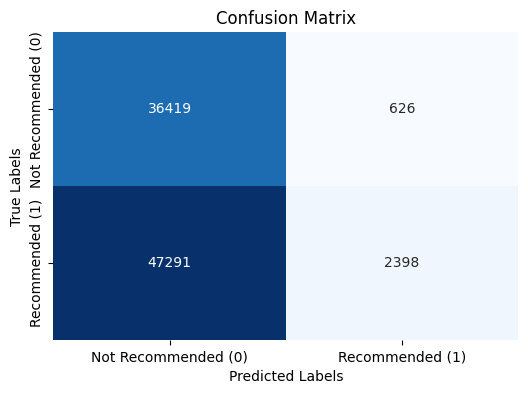

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Recommended (0)', 'Recommended (1)'], 
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

